<H1><center>Predict future sales</center></H1>

Here I am predicting total sales for every product and store in the next month.

The data is provided as daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. 



### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


### Dependencies

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm, tqdm_notebook

tqdm.monitor_interval = 0

from itertools import product
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Loading data

In [2]:
sales = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

In [3]:
test_block = sales['date_block_num'].iloc[-1] + 1
test['date_block_num'] = test_block
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [5]:
sales.shape

(2935849, 6)

In [6]:
test.shape

(214200, 4)

In [7]:
target_range = [0, 20]

# Get a feature matrix

In [31]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid = pd.concat([grid, test])


In [10]:
grid.shape

(11128050, 4)

In [12]:
gb = sales.groupby(['shop_id', 'item_id','date_block_num']).item_cnt_day.agg(['sum']).reset_index()
gb['target'] = gb['sum']
gb.drop('sum',axis=1,inplace=True)
# Fix column names
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [13]:
gb.shape

(1609124, 4)

In [14]:
gb

,shop_id,item_id,date_block_num,target
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
...,...,...,...,...
1609119,59,22164,27,2.0
1609120,59,22164,30,1.0
1609121,59,22167,9,1.0
1609122,59,22167,11,2.0


In [15]:
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).item_cnt_day.agg(['sum']).reset_index() #agg({'item_cnt_day':{'target_shop':'sum'}})
gb['target_shop'] = gb['sum']
gb.drop('sum',axis=1,inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [16]:
# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).item_cnt_day.agg(['sum']).reset_index() #agg({'item_cnt_day':{'target_item':'sum'}})
gb['target_item'] = gb['sum']
gb.drop('sum',axis=1,inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [17]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [35]:
sales['item_cnt_day'].mean()

1.242640885140891

In [19]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(['ID'] + index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

<ipython-input-19-6d9c0b48b9bd>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for month_shift in tqdm_notebook(shift_range):


In [20]:
all_data.head(5)

,shop_id,item_id,date_block_num,ID,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
4488756,54,10297,12,0.0,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,54,10296,12,0.0,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,54,10298,12,0.0,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,54,10300,12,0.0,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,54,10284,12,0.0,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0


# Feature Extraction

In [16]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items.drop(columns='item_name', inplace=True)
items.head()

,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,40,41,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,76,68,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637898,0.0,0.0,0.0,0.0,0.442678,0.0,0.0,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,2,40,45,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,3,40,47,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,4,40,43,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)  #Lenth of Item Category Description
item_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
item_cats.drop(columns='item_category_name', inplace=True)
item_cats.head()

,item_category_id,item_category_name_len,item_category_name_wc,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,0,23,3,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,16,3,0.0,0.0,0.0,0.0,0.780837,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,16,3,0.0,0.0,0.0,0.0,0.000000,0.780837,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.780837,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name
shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops.drop(columns='shop_name', inplace=True)
shops.head()

,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.905675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


In [14]:
#Items features
all_data = pd.merge(all_data, items, how='left', on='item_id')
#Item Category features
all_data = pd.merge(all_data, item_cats, how='left', on='item_category_id')
#Shops features
all_data = pd.merge(all_data, shops, how='left', on='shop_id')
all_data = downcast_dtypes(all_data)

In [19]:
all_data.head()

,shop_id,item_id,date_block_num,ID,target,target_item,target_lag_1_x,target_item_lag_1_x,target_lag_2,target_item_lag_2,target_lag_3,target_item_lag_3,target_lag_4,target_item_lag_4,target_lag_5,target_item_lag_5,target_lag_12,target_item_lag_12,target_lag_1_y,target_item_lag_1_y,target_item_lag_1_lag_1,target_item_lag_12_lag_1,target_item_lag_2_lag_1,target_item_lag_3_lag_1,target_item_lag_4_lag_1,target_item_lag_5_lag_1,target_lag_1_lag_1,target_lag_12_lag_1,target_lag_2_lag_1,target_lag_3_lag_1,target_lag_4_lag_1,target_lag_5_lag_1
0,54,10297,12,0.0,4.0,23.0,3.0,42.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54,10296,12,0.0,3.0,17.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54,10298,12,0.0,14.0,182.0,21.0,369.0,119.0,1309.0,7.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,10300,12,0.0,3.0,26.0,1.0,54.0,31.0,361.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54,10284,12,0.0,1.0,3.0,0.0,4.0,0.0,3.0,0.0,5.0,0.0,3.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
all_data.shape

(6639294, 25)

# Train/Test split

In [22]:
dates = all_data['date_block_num']
print('Test `date_block_num` is %d' % test_block)

Test `date_block_num` is 34


In [26]:
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

# First level models

Here I am implementing a basic stacking scheme.Here I use first level models to build two datasets: test meta-features and 2-nd level train-metafetures.

## Test meta-features

First, I will run linear regression on numeric columns and get predictions for the test month.

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

In [33]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.022755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Finally, concatenate test predictions to get test meta-features.

In [34]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

## Train meta-features

In [35]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

In [36]:
# And here we create 2nd level feeature matrix, init it with zeros first# And he 
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
pbar = tqdm_notebook(dates_train_level2.unique())
for cur_block_num in pbar:
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           We can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    pbar.set_description('{}: Split'.format(cur_block_num))
    _X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    _X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    _y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    _y_test =  all_data.loc[dates == cur_block_num, 'target'].values
    
    pbar.set_description('{}: LR'.format(cur_block_num))
    lr.fit(_X_train.values, _y_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(_X_test.values).clip(*target_range)
    
    pbar.set_description('{}: LGB'.format(cur_block_num))
    model = lgb.train(lgb_params, lgb.Dataset(_X_train, label=_y_train), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(_X_test).clip(*target_range)

<ipython-input-36-a1a9eb16398c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm_notebook(dates_train_level2.unique())


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.750162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.832893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.910187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.850518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

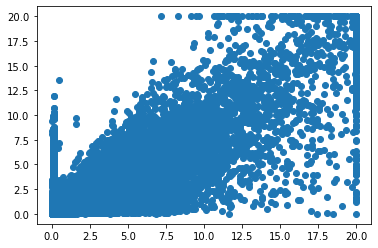

In [37]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

## Simple Convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

I need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array.

In [38]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.078821


Now use the  𝛼  we've found to compute predictions for the test set

In [39]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_averaging.csv', index=False)

## Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [40]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression()

Compute R-squared on the train and test sets.

In [41]:
train_preds = lr.predict(X_train_level2).clip(*target_range)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(np.vstack((pred_lr, pred_lgb)).T).clip(*target_range)
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_stacking.csv', index=False)

print('Train R-squared for stacking is %f' % r2_train_stacking)

Train R-squared for stacking is 0.072424
